In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from io import StringIO
from IPython.display import Image, display
import pydotplus

## 

In [24]:
# Carga de los datos
data = pd.read_excel('Real estate valuation data set.xlsx')

## Data Preparation

In [25]:
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [26]:
# Renaming columns
data.columns = ['no','transaction_date','house_age','distance_to_station','n_stores','latitude','longitude','price']

# Dropping column 'no'
data.drop('no', axis=1, inplace=True)

# Converting dtype of 'transaction_date'
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format='%Y/%m/%d')

## Exploratory Data Analysis

In [27]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   transaction_date     414 non-null    datetime64[ns]
 1   house_age            414 non-null    float64       
 2   distance_to_station  414 non-null    float64       
 3   n_stores             414 non-null    int64         
 4   latitude             414 non-null    float64       
 5   longitude            414 non-null    float64       
 6   price                414 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 22.8 KB


In [21]:
# Number of unique values by feature
data.nunique()

transaction_date        12
house_age              236
distance_to_station    259
n_stores                11
latitude               234
longitude              232
price                  270
dtype: int64

### Distribution of price

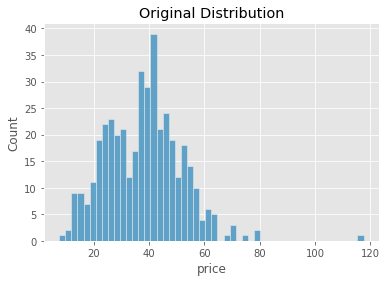

(<AxesSubplot:title={'center':'Original Distribution'}, xlabel='price', ylabel='Count'>,
 None)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Original price distribution
plt.title('Original Distribution')
sns.histplot(data.price, bins=50), plt.show()

In [32]:
# Converting price distribution to lognormal
price_logs = np.log1p(data.price)

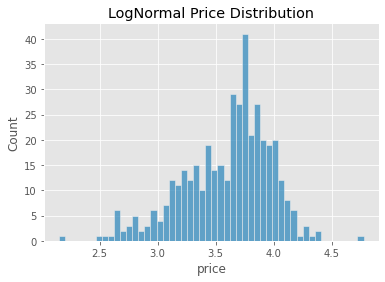

(<AxesSubplot:title={'center':'LogNormal Price Distribution'}, xlabel='price', ylabel='Count'>,
 None)

In [34]:
# Original price distribution
plt.title('LogNormal Price Distribution')
sns.histplot(price_logs, bins=50), plt.show()

### Missing Values

In [35]:
data.isnull().sum()

transaction_date       0
house_age              0
distance_to_station    0
n_stores               0
latitude               0
longitude              0
price                  0
dtype: int64

### Visualización de datos geográficos

Contamos con datos geográficos(longitud, latitud). Los visualizamos para buscar patrones.  


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

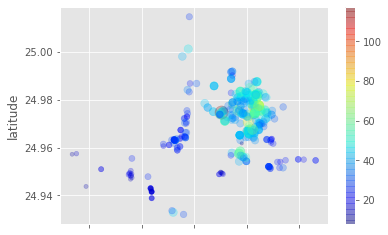

In [8]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=.25,
          s=data['price']*1.5,c=data['price'], cmap=plt.get_cmap('jet'), colorbar=True)

Podemos observar que existe un área donde se concentran una gran cantidad de viviendas con precios medios-altos, sin embargo, en esta área se puede observar que hay instancias con valores bajos. Las vivivendas de precios más bajos, se encuentran dispersas, por lo general, alejadas del área anteriormente mencionada. 

### Correlaciones

In [9]:
corr_matrix = data.corr(method='spearman')
corr_matrix['price'].sort_values()

distance_to_station   -0.775948
house_age             -0.281753
longitude              0.437672
latitude               0.578419
n_stores               0.617333
price                  1.000000
Name: price, dtype: float64

Mediante el coeficiente de correlación (de Spearman), podemos resaltar que:
* La distancia hasta la estación del metro(distance_to_station) y,
* La cantidad de tiendas de conveniencias cercanas(n_store), 

están fuertemente correlacionadas con el precio de las viviendas. Más, esto no significa causalidad.

## <b>Modelo (Bosque Aleatorio)

In [10]:
# Datos de entrada
# ================================================================
X = data
y = data.pop('price')
X.head(2)

,house_age,distance_to_station,n_stores,latitude,longitude
0,32.0,84.87882,10,24.98298,121.54024
1,19.5,306.59470,9,24.98034,121.53951


In [11]:
# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=.3)

### DecisionTreeRegressor

Algoritmo de Árbol de decisión (Regresión) con parámetros por defecto.

In [12]:
# Regresor de Bosque Aleatorio
# Entrenamiento del modelo
# =====================================================================
randomf_reg = RandomForestRegressor(random_state=0)
randomf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [13]:
importancia_predictores = pd.DataFrame(
                            {'predictor': data.columns,
                             'importancia': randomf_reg.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,distance_to_station,0.608068
0,house_age,0.167869
4,longitude,0.100956
3,latitude,0.100732
2,n_stores,0.022376


Nuestro modelo de bosque aleatorio como el coeficiente de correlación nos indican que "distance_to_station" es la variable que mayor información nos aporta para la regresión de nuestra variable objetivo.

### Validación Cruzada (10 k-folds)

Realizo una validación cruzada de 10 k-folds para evaluar la capacidad de predicción del modelo (con los hiperparámetros por defecto).

In [14]:
# Cross-Validation
# =====================================================================
y_preds = cross_val_score(randomf_reg, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
rf_rmse = np.sqrt(-y_preds)
print('RMSE de los 10 k-folds:')
print(rf_rmse)
print()
rf_rmse_mean = round(np.mean(rf_rmse),2)
rf_rmse_std = round(np.std(rf_rmse),2)
print(f'RMSE promedio: {rf_rmse_mean}, desviación: {rf_rmse_std}')

RMSE de los 10 k-folds:
[ 6.06883631 15.13032459  5.60258963  7.78305387  9.54635335  5.78060085
  6.52780971  9.00321417  5.23699947  7.37638103]

RMSE promedio: 7.81, desviación: 2.8


### Ajuste del modelo

In [15]:
modelo = RandomForestRegressor(random_state=123)     
modelo.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [49]:
# Hiperparámetros - RandomForest
# ==========================================================================

# Método de selección de muestra
bootstrap = [True, False]
# Niveles máximos en cada árbol
max_depth = [x for x in np.arange(10, 150, step=10)]
# Cantidad de características a considerar para cada división
max_features = ['auto', 'sqrt']
# Cantidad mínima de muestras requeridas para un nodo hoja
min_samples_leaf = [x for x in np.arange(0, 30, step=5)]
# Cantidad mínimas de muestras para dividir un nodo
min_samples_split = [x for x in np.arange(0, 30, step=5)]
# Cantidad de árboles
n_estimators = [x for x in np.arange(30, 500, step=25)]

param_distributions = {
    'bootstrap'         : bootstrap,
    'max_depth'         : max_depth,
    'max_features'      : max_features,
    'min_samples_leaf'  : min_samples_leaf,
    'min_samples_split' : min_samples_split,
    'n_estimators'      : n_estimators,
}

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=modelo, 
                        param_distributions=param_distributions,
                        scoring='neg_mean_squared_error',
                        cv=10, 
                        n_jobs=-1, 
                        random_state=40)    

random_search.fit(X_train, y_train)

/home/pablo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-75.81737742 -79.38904063 -68.75695039 -71.17399582          nan
 -73.60149797 -74.57415289 -67.97042075 -69.1888788           nan]
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0, 5, 10, 15, 20,
                                                             25],
                                        'min_samples_split': [0, 5, 10, 15, 20,
                                                              25],
                                        'n_estimators': [30, 55, 80, 105, 130,
                                                         155, 180, 205, 230,
                                                         255, 280, 305, 330,
  

In [50]:
random_search.best_params_

{'n_estimators': 330,
 'min_samples_split': 15,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [51]:
def evaluate(model, X_train, y_train):
    y_preds = cross_val_score(model, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
    scores = np.sqrt(-y_preds)
    model_score = np.mean(scores)
    print('Model Performance')
    print('Root Mean Squared Error: {:0.4f}'.format(model_score))
    
    return model_score

In [52]:
#base_model.fit(X_train, y_train)
base_rmse = evaluate(randomf_reg, X_train, y_train)

Model Performance
Root Mean Squared Error: 7.8056


In [53]:
best_random = random_search.best_estimator_
random_rmse = evaluate(best_random, X_train, y_train)

Model Performance
Root Mean Squared Error: 7.7283


#### GridSearchCV

In [54]:
random_search.best_params_

{'n_estimators': 330,
 'min_samples_split': 15,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [55]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators':      [i for i in np.arange(325,335)],
    'min_samples_split': [i for i in np.arange(11, 25)],
    'min_samples_leaf':  [i for i in np.arange(1, 10)],
    'max_features':      ['sqrt'],
    'max_depth':         [i for i in np.arange(75, 85)],
    'bootstrap':         [False]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [56]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12600 candidates, totalling 37800 fits


KeyboardInterrupt: 

In [47]:
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'